# Setup and Imports

In [1]:
!nvidia-smi

Fri Feb 28 12:49:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
import shutil
import gdown
import torch
import numpy as np, cv2, pandas as pd, glob, time
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
%matplotlib inline

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Loading

In [4]:
urls = {
    # "fairface-img-margin125-trainval.zip": "1g7qNOZz9wC7OfOhcPqH1EZ5bk1UFGmlL",
    "fairface-img-margin025-trainval.zip": "1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86"
}

In [5]:
# Loading the images data
for filename, file_id in urls.items():
    print(f"Downloading {filename}...")
    gdown.download(f"https://drive.google.com/uc?id={file_id}", filename, quiet=False)
    print(f"Unzipping {filename}...")
    !unzip -qq {filename}
    print(f"Done with {filename}!\n")

# Loading the labels
gdown.download(f"https://drive.google.com/uc?id=1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH", "fairface_label_train.csv", quiet=False)
gdown.download(f"https://drive.google.com/uc?id=1wOdja-ezstMEp81tX1a-EYkFebev4h7D", "fairface_label_val.csv", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86
From (redirected): https://drive.google.com/uc?id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86&confirm=t&uuid=4daffc18-7514-4aa4-9f06-4efb34b4a026
To: /content/fairface-img-margin025-trainval.zip
100%|██████████| 578M/578M [00:08<00:00, 67.5MB/s]


Unzipping fairface-img-margin025-trainval.zip...
Done with fairface-img-margin025-trainval.zip!



Downloading...
From: https://drive.google.com/uc?id=1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH
To: /content/fairface_label_train.csv
100%|██████████| 3.79M/3.79M [00:00<00:00, 25.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wOdja-ezstMEp81tX1a-EYkFebev4h7D
To: /content/fairface_label_val.csv
100%|██████████| 448k/448k [00:00<00:00, 6.46MB/s]


'fairface_label_val.csv'

In [6]:
train_df = pd.read_csv("/content/fairface_label_train.csv")
val_df = pd.read_csv("/content/fairface_label_val.csv")

In [7]:
train_df.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [8]:
val_df.head()

,file,age,gender,race,service_test
0,val/1.jpg,3-9,Male,East Asian,False
1,val/2.jpg,50-59,Female,East Asian,True
2,val/3.jpg,30-39,Male,White,True
3,val/4.jpg,20-29,Female,Latino_Hispanic,True
4,val/5.jpg,20-29,Male,Southeast Asian,False


# Data Preprocessing

In [9]:
IMAGE_SIZE = 224

In [10]:
class GenderAgeClass(Dataset):

  def __init__(self, df, tfms=None):
    self.df = df
    self.normalize = transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225]
    )

  def __len__(self):
    return len(self.df)

  def __getitem__(self, ix):
    f = self.df.iloc[ix].squeeze()
    file = f.file
    gen = f.gender == 'Female'
    age = f.age
    im = cv2.imread(file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    return im, age, gen

  def preprocess_image(self, im):
    im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
    im = torch.tensor(im).permute(2,0,1)
    im = self.normalize(im/255.)

    return im[None]

  def collate_fn(self, batch):
      ims, ages, genders = [], [], []

      for im, age, gender in batch:
          im = self.preprocess_image(im)
          ims.append(im)

          # Handling age values, including ranges and special cases
          if '-' in age:  # For ranges like '10-19'
              age_min, age_max = map(int, age.split('-'))
              age = (age_min + age_max) / 2  # Taking the midpoint
          elif 'more than' in age:  # For cases like 'more than 70'
              age = 75  # Approximation for 'more than 70'
          else:
              try:
                  age = int(age)  # Converting single age to integer
              except ValueError:
                  raise ValueError(f"Unexpected age value: {age}")

          ages.append(float(age) / 80)  # Normalizing age
          genders.append(float(gender))

      ages, genders = [torch.tensor(x).to(device).float() \
                      for x in [ages, genders]]
      ims = torch.cat(ims).to(device)

      return ims, ages, genders

In [11]:
train = GenderAgeClass(train_df)
val = GenderAgeClass(val_df)

In [12]:
train_loader = DataLoader(train, batch_size=32, shuffle=True, drop_last=True,collate_fn=train.collate_fn)

test_loader = DataLoader(val, batch_size=32, collate_fn=val.collate_fn)

a,b,c, = next(iter(train_loader))

print(a.shape, b.shape, c.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32])


# Model Architecture

In [13]:
def get_model():
  model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

  for param in model.parameters():
    param.requires_grad = False

  model.avgpool = nn.Sequential(
    nn.Conv2d(512,512, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten()
  )

  class ageGenderClassifier(nn.Module):

    def __init__(self):
      super(ageGenderClassifier, self).__init__()

      self.intermediate = nn.Sequential(
        nn.Linear(2048,512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512,128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128,64),
        nn.ReLU(),
      )

      self.age_classifier = nn.Sequential(
        nn.Linear(64, 1),
        nn.Sigmoid()
      )

      self.gender_classifier = nn.Sequential(
        nn.Linear(64, 1),
        nn.Sigmoid()
      )

    def forward(self, x):
      x = self.intermediate(x)
      age = self.age_classifier(x)
      gender = self.gender_classifier(x)

      return gender, age

  model.classifier = ageGenderClassifier()

  gender_criterion = nn.BCELoss()
  age_criterion = nn.L1Loss()
  loss_functions = gender_criterion, age_criterion
  optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr= 1e-5, weight_decay=1e-4)

  return model.to(device), loss_functions, optimizer

In [14]:
model, criterion, optimizer = get_model()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 90.1MB/s]


# Training and Validation

In [15]:
def train_batch(data, model, optimizer, criteria):
  model.train()

  ims, age, gender = data
  optimizer.zero_grad()
  pred_gender, pred_age = model(ims)

  gender_criterion, age_criterion = criteria
  gender_loss = gender_criterion(pred_gender.squeeze(), gender)
  age_loss = age_criterion(pred_age.squeeze(), age)

  total_loss = gender_loss + age_loss
  total_loss.backward()
  optimizer.step()

  return total_loss

In [16]:
def validate_batch(data, model, criteria):
  model.eval()

  img, age, gender = data

  with torch.no_grad():
   pred_gender, pred_age = model(img)

  gender_criterion, age_criterion = criteria
  gender_loss = gender_criterion(pred_gender.squeeze(), gender)
  age_loss = age_criterion(pred_age.squeeze(), age)

  total_loss = gender_loss + age_loss
  pred_gender = (pred_gender > 0.5).squeeze()
  gender_acc = (pred_gender == gender).float().sum()
  age_mae = torch.abs(age - pred_age).float().sum()

  return total_loss, gender_acc, age_mae

In [17]:
import time
import tqdm

val_gender_accuracies = []
val_age_maes = []
train_losses = []
val_losses = []
n_epochs = 3
best_test_loss = 1000
start = time.time()

for epoch in range(n_epochs):
    epoch_train_loss, epoch_test_loss = 0, 0
    val_age_mae, val_gender_acc, ctr = 0, 0, 0
    _n = len(train_loader)

    for ix, data in tqdm.tqdm_notebook(enumerate(train_loader), total=_n, desc=f"Epoch {epoch+1} Training"):
        loss = train_batch(data, model, optimizer, criterion)
        epoch_train_loss += loss.item()

    for ix, data in tqdm.tqdm_notebook(enumerate(test_loader), total=len(test_loader), desc=f"Epoch {epoch+1} Validation"):
        loss, gender_acc, age_mae = validate_batch(data, model, criterion)
        epoch_test_loss += loss.item()
        val_age_mae += age_mae
        val_gender_acc += gender_acc
        ctr += len(data[0])

    # Computing metrics
    val_age_mae /= ctr
    val_gender_acc /= ctr
    epoch_train_loss /= len(train_loader)
    epoch_test_loss /= len(test_loader)

    elapsed = time.time() - start
    best_test_loss = min(best_test_loss, epoch_test_loss)
    print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(
        epoch + 1, n_epochs, elapsed, (n_epochs - epoch - 1) * (elapsed / (epoch + 1))
    ))

    info = f'''
    Train Loss: {epoch_train_loss:.3f}
    Test Loss: {epoch_test_loss:.3f}
    Best Test Loss: {best_test_loss:.4f}
    '''

    info += f'\nGender Accuracy: {val_gender_acc * 100:.2f}%\tAge MAE: {val_age_mae:.2f}\n'

    print(info)

    # Tracking metrics
    val_gender_accuracies.append(val_gender_acc)
    val_age_maes.append(val_age_mae)
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_test_loss)

<ipython-input-17-d5e541cd76c9>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ix, data in tqdm.tqdm_notebook(enumerate(train_loader), total=_n, desc=f"Epoch {epoch+1} Training"):


Epoch 1 Training:   0%|          | 0/2710 [00:00<?, ?it/s]

<ipython-input-17-d5e541cd76c9>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ix, data in tqdm.tqdm_notebook(enumerate(test_loader), total=len(test_loader), desc=f"Epoch {epoch+1} Validation"):


Epoch 1 Validation:   0%|          | 0/343 [00:00<?, ?it/s]

1/3 (766.30s - 1532.59s remaining)

    Train Loss: 0.701
    Test Loss: 0.587
    Best Test Loss: 0.5869
    
Gender Accuracy: 77.49%	Age MAE: 5.86



Epoch 2 Training:   0%|          | 0/2710 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/343 [00:00<?, ?it/s]

2/3 (1539.54s - 769.77s remaining)

    Train Loss: 0.559
    Test Loss: 0.530
    Best Test Loss: 0.5304
    
Gender Accuracy: 80.56%	Age MAE: 6.10



Epoch 3 Training:   0%|          | 0/2710 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/343 [00:00<?, ?it/s]

3/3 (2299.52s - 0.00s remaining)

    Train Loss: 0.503
    Test Loss: 0.510
    Best Test Loss: 0.5101
    
Gender Accuracy: 81.37%	Age MAE: 6.11



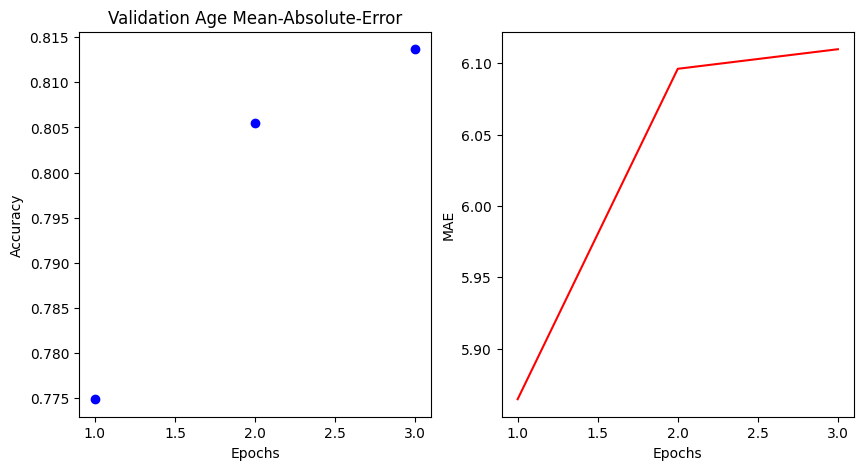

In [18]:
epochs = np.arange(1,(n_epochs+1))

# Ensuring all tensors are on the CPU and converted to NumPy arrays
val_gender_accuracies = [x.cpu().numpy() for x in val_gender_accuracies]
val_age_maes = [x.cpu().numpy() for x in val_age_maes]

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax = ax.flat

ax[0].plot(epochs, val_gender_accuracies, 'bo')
ax[1].plot(epochs, val_age_maes, 'r')
ax[0].set_xlabel('Epochs') ; ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy'); ax[1].set_ylabel('MAE')
ax[0].set_title('Validation Gender Accuracy')
ax[0].set_title('Validation Age Mean-Absolute-Error')

plt.show()

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
im = cv2.imread(r'/content/drive/MyDrive/Colab Notebooks/hosting/steven-su-kbZkBKrYBAk-unsplash.jpg')
im = train.preprocess_image(im).to(device)

In [23]:
gender, age = model(im)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()

predicted gender: Male ; Predicted age: 46


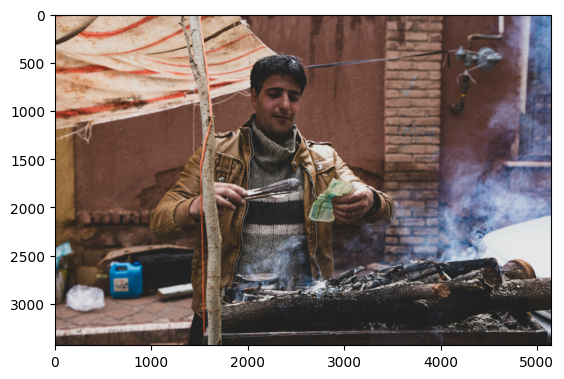

In [24]:
im = cv2.imread(r'/content/drive/MyDrive/Colab Notebooks/hosting/steven-su-kbZkBKrYBAk-unsplash.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
print('predicted gender:',np.where(pred_gender[0][0]<0.5, 'Male','Female'),'; Predicted age:', int(pred_age[0][0]*80))

# With the preceding use case, we can see that we are able to make predictions for both age and gender in a single shot. However, we need to note that this is highly unstable and that the age value varies considerably with different orientations of the image and also lighting conditions. In this case, the following two methods can be implemented to counter, such drawbacks:
- Data augmentation
- Training model where you extract the facial region only. This way, the background information is not being considered to calculate the
age and gender of a person.